# KM Pipeline（摄取管道）

KM 摄取组件利用一系列连续步骤的底层管道，接受一些数据作为输入，例如文件、URL 或字符串，并逐步将输入转换为**Memory Records（记忆记录）**。KM 使用两种存储解决方案来保存信息：

* Content Storage: 内容存储，客户端上传的原始数据、管道状态、分配给文档的唯一 ID。
* Memory Storage:  记忆存储，具有搜索功能的数据库（比如向量数据库），KM 在其中存储 Memory Records。

In [1]:
//通过引入Config/PrepareEnv.cs文件来快速安装依赖包并导入已抽象的类文件，然后注册并激活 Memory 服务：

#!import Config/PrepareEnv.cs

var memory = GetSimpleMemory();

Installed Packages dotenv.net, 3.2.1 Microsoft.KernelMemory.AI.AzureOpenAI, 0.98.250324.1 Microsoft.KernelMemory.Core, 0.98.250324.1 Microsoft.KernelMemory.MemoryDb.Qdrant, 0.98.250324.1

## 内置摄取管道


KM 中内置了多个摄取管道，定义在`Microsoft.KernelMemory.Constants`类中，其中每个摄取管道都有多个步骤组成，每个步骤都有对应的`Handler` 进行处理。其中内置的步骤主要有：
1. extract: 提取，由`TextExtractionHandler` 进行处理。此处理程序通常是第一个被调用的，它接收一个文件并提取文本，同时也负责OCR和文件类型检测。如果客户端提供一个 URL，该处理程序会下载网页并提取文本。此处理程序的输出保存在内容存储中，以供后续处理程序进一步处理。

2. partition：分片，由`TextPartitioningHandler` 进行处理。 此处理程序将由上一个处理器创建的文本文件按照配置拆分为多个小块（Chunks）。默认处理器将文本按句子（也称为“行”）拆分，并将它们聚合在段落（也称为“Partition（分区）”）中。行/句子/段落/分区的大小以标记数来衡量。一旦分区准备好，它们就会被保存到相同的内容存储中，为下一步做好准备。目前，分区文件被保存为原始文本文件。另外，默认处理器不理解代码语法、聊天记录、JSON 或其他结构化数据，这些总是被视为字符串处理。如果需要处理特定格式，请自定义处理器，以便更好地进行分割。

3. gen_embeddings: 生成嵌入向量，由`GenerateEmbeddingsHandler` 进行处理。该处理程序会加载每个分区文件，获取文本并使用已配置的嵌入生成器计算嵌入向量。该向量被序列化为 JSON 并保存回内容存储中。这个处理程序一次处理一个分区，没有任何并行性，并且耗时根据所使用的大语言模型的性能表现而不同，完成可能需要几毫秒到几分钟的时间。

4. save_records： 保存记录，由`SaveRecordsHandler`进行处理。此处理程序将上一个处理程序生成的嵌入存储在一个或多个Memory DB中，包括有关源的信息，包括分区文本、标签和其他对搜索有用的元数据。此操作通常非常快，并且会在提供的文档 ID 与先前上传的文档 ID 匹配的情况下负责更新现有记录。

5. summarize：生成摘要，由`SummarizationHandler`进行处理。这是一个可选的处理程序，客户端可以要求使用它来生成和存储上传文件的摘要。由于摘要可能很耗时，因此建议在 `save_records` 和`partition` 和`gen_embeddings` 之后使用。为了提供最佳的用户体验，最好在`save_records`后运行，如此用户可以立即开始提问，因为合成数据生成可能需要很长时间才能生成，例如总结一本书可能需要几分钟。

  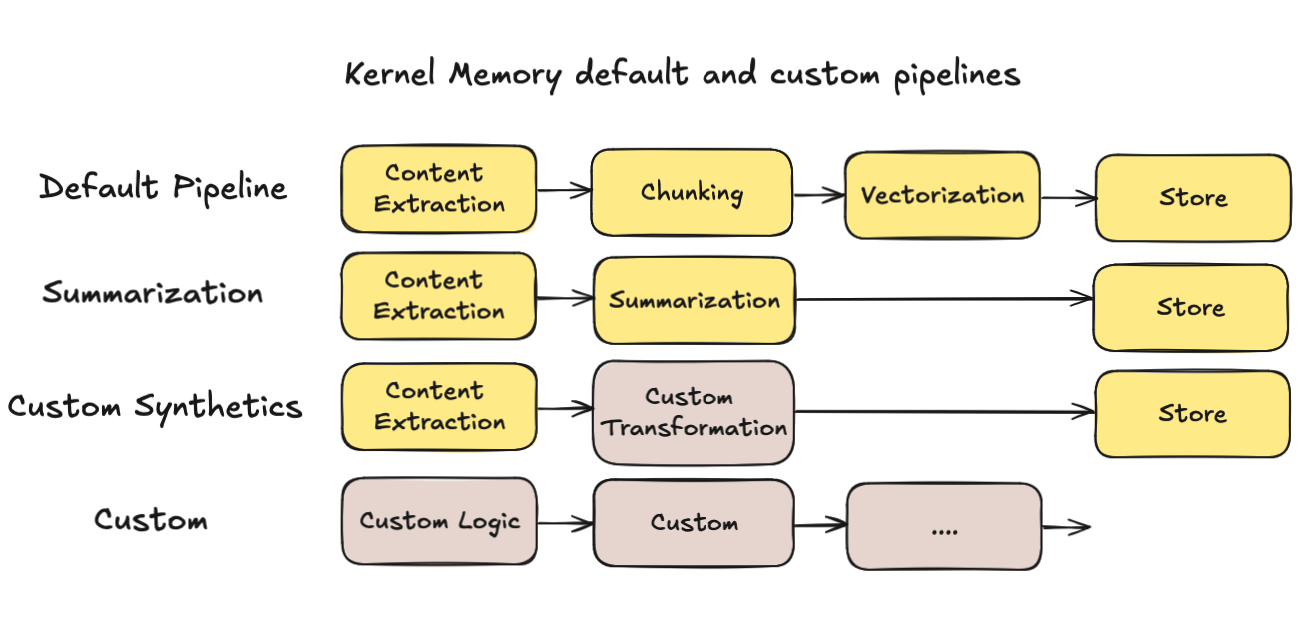

通过对这几个步骤的排列组合，可以形成不同的流程，以下是内置的四种流程：
1. DefaultPipeline：即对导入的文档分片然后生成嵌入向量保存。
2. PipelineWithoutSummary：等同于`DefaultPipeline`。
3. PipelineWithSummary：在`DefaultPipeline`的基础上再对每个分片进行摘要并生成嵌入向量保存。
4. PipelineOnlySummary：即对导入的文档直接生成摘要，然后对摘要生成嵌入向量保存。
```
namespace Microsoft.KernelMemory;
public static class Constants
{
  public static readonly string[] DefaultPipeline = new string[4]
  {
    "extract",
    "partition",
    "gen_embeddings",
    "save_records"
  };
  public static readonly string[] PipelineWithoutSummary = new string[4]
  {
    "extract",
    "partition",
    "gen_embeddings",
    "save_records"
  };
  public static readonly string[] PipelineWithSummary = new string[7]
  {
    "extract",
    "partition",
    "gen_embeddings",
    "save_records",
    "summarize",
    "gen_embeddings",
    "save_records"
  };
  public static readonly string[] PipelineOnlySummary = new string[4]
  {
    "extract",
    "summarize",
    "gen_embeddings",
    "save_records"
  };
}  
```

## 指定摄取流程

KM 提供了系列接口去导入数据源（文本、文件、网页），每个方法都有多个重载：
* ImportDocumentAsync：用于导入文件，支持一次导入多个文件
* ImportTextAsync：用于导入文本
* ImportWebPageAsync：用于导入网页

其中每个方法，都有以下几个可选参数，其中`steps` 参数就是用来指定摄取管道：
* documentId： 文档 ID，不指定则系统会随机生成一个ID
* tags：标签，key-value 集合
* index：索引，不指定时，则默认值为`default`
* steps：步骤，字符串数组，用于指定管道流程

接下来以`ImportTextAsync` 为例，讲解如何指定摄取流程。

In [2]:
var text = """
Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes.
""";

1. 使用默认嵌入流程：

    以下三种方式都将使用默认嵌入流程：
    1. 不指定`steps` 参数
    2. `steps` 参数设定为：`steps: Microsoft.KernelMemory.Constants.DefaultPipeline`
    3. `steps` 参数设定为：`steps: ["extract", "partition", "gen_embeddings", "save_records"]`

In [3]:
await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index"); // 不指定 steps 参数，即使用的是默认的流程

In [ ]:
await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index",
    steps: Microsoft.KernelMemory.Constants.DefaultPipeline); // 显式指定使用默认流程

In [3]:
await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index",
    steps: ["extract", "partition", "gen_embeddings", "save_records"]);

In [4]:
var answer = await memory.AskAsync(question: "What is KM index?", index: "kernel-memory-index");
answer.Display();

In the context provided, a KM (Kernel Memory) index refers to a collection within the Kernel Memory system that is used to store and manage data. Each index is a distinct collection that holds the meaning of the documents ingested into the service. These indexes are used to ensure that data is kept ... StreamState <null> Question What is KM index? NoResult False NoResultReason <null> Result In the context provided, a KM (Kernel Memory) index refers to a collection within the Kernel Memory system that is used to store and manage data. Each index is a distinct collection that holds the meaning of the documents ingested into the service. These indexes are used to ensure that data is kept separate for reasons such as security and privacy. When storing information, searching, or asking questions, Kernel Memory operates strictly within the boundaries of a single index, ensuring that data from one index does not leak into another. TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 03:11:21Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 182 TokenizerTokensOut 102 ServiceTokensIn 186 ServiceTokensOut 103 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/e8de865e720e4b288c51b0bd5fe90ad5 Index kernel-memory-index DocumentId km_concept_index FileId e8de865e720e4b288c51b0bd5fe90ad5 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.790519 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:11:19Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ e8de865e720e4b288c51b0bd5fe90ad5 ] __file_part [ 4abee05580be4bee95d2bc24d7c0b7d4 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ]

2. 使用摘要流程

In [5]:
await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index",
    steps: Microsoft.KernelMemory.Constants.PipelineOnlySummary); 

In [6]:
var answer = await memory.AskAsync(question: "What is KM index?", index: "kernel-memory-index");
answer.Display();
var summary = await memory.SearchSummariesAsync(index: "kernel-memory-index");
summary.Display();

A KM index in Kernel Memory refers to a collection used for storing, searching, and querying data. Each index is a distinct collection that captures the meaning of documents using vector storage, similar to solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. The use of indexes ensures... StreamState <null> Question What is KM index? NoResult False NoResultReason <null> Result A KM index in Kernel Memory refers to a collection used for storing, searching, and querying data. Each index is a distinct collection that captures the meaning of documents using vector storage, similar to solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. The use of indexes ensures that operations are confined to a single collection, preventing data leakage between different collections, which is important for maintaining security and privacy. TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 03:11:50Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 157 TokenizerTokensOut 84 ServiceTokensIn 162 ServiceTokensOut 85 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/b412261166c54045ad1f1a22891417d2 Index kernel-memory-index DocumentId km_concept_index FileId b412261166c54045ad1f1a22891417d2 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory uses vector storage to capture the meaning of documents, similar to solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Storage solutions have a maximum capacity for each collection, requiring data separation into distinct collections for security and privacy. In Kernel Memory, these collections are called "indexes." Operations such as storing information, searching, and querying are confined to a single index, ensuring data does not leak between indexes. Relevance 0.7469811 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:11:44Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ b412261166c54045ad1f1a22891417d2 ] __file_part [ cf58ec4d3adf45dc963a882e311729f4 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] __synth [ summary ]

index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/b412261166c54045ad1f1a22891417d2 Index kernel-memory-index DocumentId km_concept_index FileId b412261166c54045ad1f1a22891417d2 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory uses vector storage to capture the meaning of documents, similar to solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Storage solutions have a maximum capacity for each collection, requiring data separation into distinct collections for security and privacy. In Kernel Memory, these collections are called "indexes." Operations such as storing information, searching, and querying are confined to a single index, ensuring data does not leak between indexes. Relevance -Infinity PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:11:44Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ b412261166c54045ad1f1a22891417d2 ] __file_part [ cf58ec4d3adf45dc963a882e311729f4 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] __synth [ summary ]

3. 使用嵌入+摘要流程

In [7]:
await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index",
    steps: Microsoft.KernelMemory.Constants.PipelineWithSummary); 

In [8]:
var answer = await memory.AskAsync(question: "What is KM index?", index: "kernel-memory-index");
answer.Display();

A KM index in Kernel Memory refers to a collection used to store, search, and query data. Kernel Memory uses vector storage to capture the meaning of documents and works with solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Each index has a maximum capacity and is separated from ot... StreamState <null> Question What is KM index? NoResult False NoResultReason <null> Result A KM index in Kernel Memory refers to a collection used to store, search, and query data. Kernel Memory uses vector storage to capture the meaning of documents and works with solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Each index has a maximum capacity and is separated from others for security, privacy, or other important reasons. All operations are confined within a single index, ensuring that data does not leak between different indexes. TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 03:13:46Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 280 TokenizerTokensOut 90 ServiceTokensIn 284 ServiceTokensOut 91 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/f7dbbf52bd42421b83b51ade2646d6da Index kernel-memory-index DocumentId km_concept_index FileId f7dbbf52bd42421b83b51ade2646d6da SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.790519 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:13:01Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ f7dbbf52bd42421b83b51ade2646d6da ] __file_part [ 0e17a1150aad460ead7f29fad8b22089 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] 1 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory uses vector storage to capture the meaning of documents. It works with solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Each collection has a maximum capacity and must be separated for security or privacy reasons. In Kernel Memory, these collections are called "indexes." All operations, including storing, searching, and querying, occur within a single index, ensuring data does not leak between indexes. Relevance 0.74856585 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:13:04Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ f7dbbf52bd42421b83b51ade2646d6da ] __file_part [ 31becfa8e91e4cf488c6cd1b4051c1ab ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] __synth [ summary ]

In [9]:
var summary = await memory.SearchSummariesAsync(index: "kernel-memory-index");
summary.Display();

index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/f7dbbf52bd42421b83b51ade2646d6da Index kernel-memory-index DocumentId km_concept_index FileId f7dbbf52bd42421b83b51ade2646d6da SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory uses vector storage to capture the meaning of documents. It works with solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. Each collection has a maximum capacity and must be separated for security or privacy reasons. In Kernel Memory, these collections are called "indexes." All operations, including storing, searching, and querying, occur within a single index, ensuring data does not leak between indexes. Relevance -Infinity PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 19:13:04Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ f7dbbf52bd42421b83b51ade2646d6da ] __file_part [ 31becfa8e91e4cf488c6cd1b4051c1ab ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] __synth [ summary ]